In [57]:
import pandas as pd 
import matplotlib.pyplot as plt 

In [58]:
df = pd.read_csv('conso-hdf.csv', index_col=0)
df.index = pd.to_datetime(df.date)
df_day = df.resample('D').mean()
df_month = df.resample('M').mean()


/tmp/ipykernel_41496/1221404872.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_day = df.resample('D').mean()
/tmp/ipykernel_41496/1221404872.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_month = df.resample('M').mean()


In [64]:
df.set_index('date',inplace=True)

<AxesSubplot: xlabel='date'>

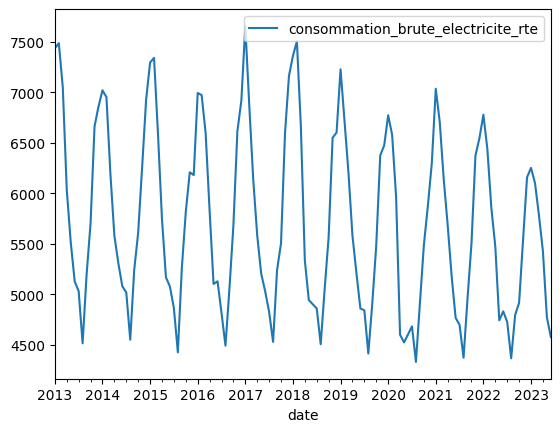

In [65]:
df_month.plot()

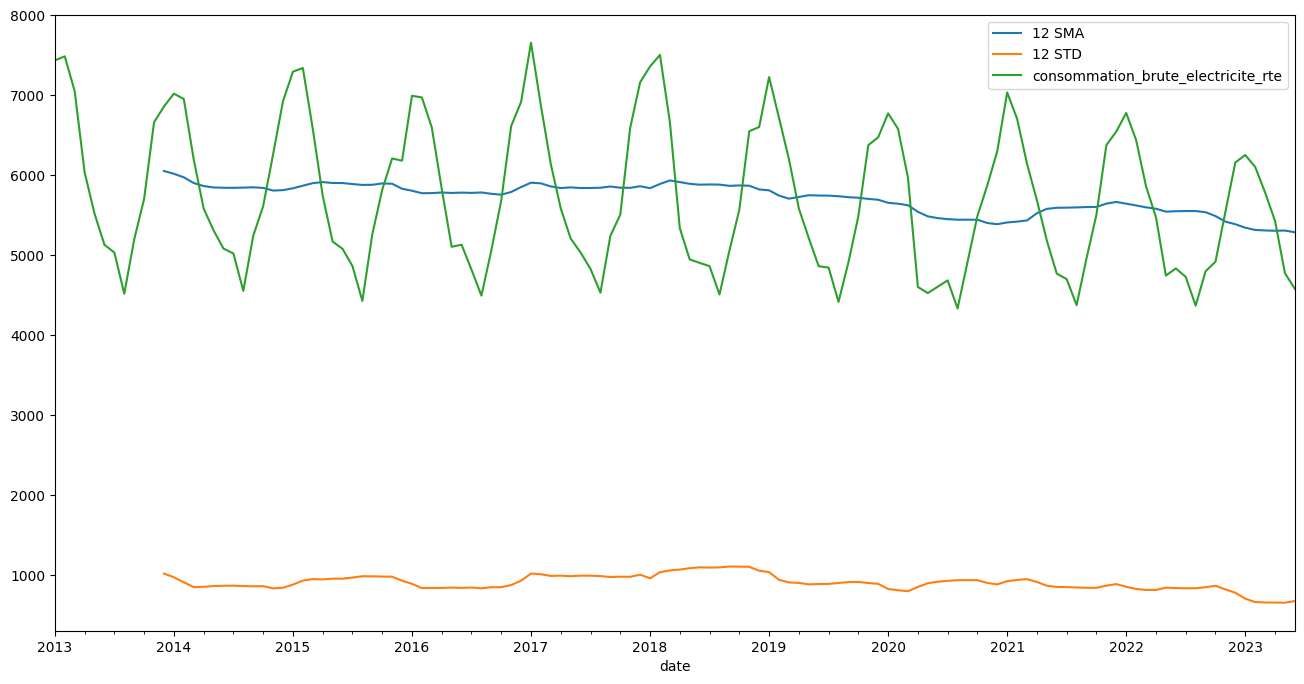

In [66]:
df_month['consommation_brute_electricite_rte'].rolling(12).mean().plot(label='12 SMA',figsize=(16,8))
df_month['consommation_brute_electricite_rte'].rolling(12).std().plot(label='12 STD')
df_month['consommation_brute_electricite_rte'].plot()
plt.legend()

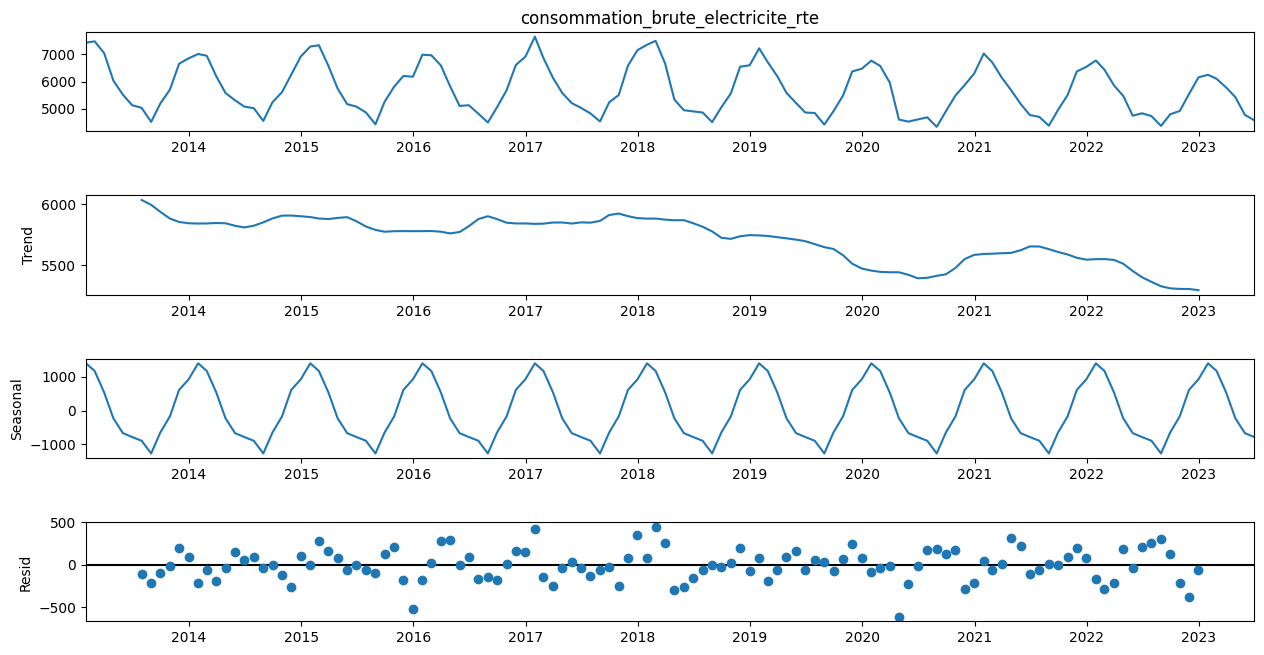

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df_month['consommation_brute_electricite_rte'])
fig = decomp.plot()
fig.set_size_inches(14,7)


In [68]:
from statsmodels.tsa.stattools import adfuller
fuller_test = adfuller(df_month['consommation_brute_electricite_rte'])
fuller_test


(-0.6243772422702117,
 0.8653780878361141,
 12,
 113,
 {'1%': -3.489589552580676,
  '5%': -2.887477210140433,
  '10%': -2.580604145195395},
 1572.9850205777673)

In [69]:
def test_p_value(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Reject null hypothesis, data is stationary')
        else:
            print('Do not reject null hypothesis, data is not stationary')
            
test_p_value(df_month['consommation_brute_electricite_rte'])

P-value:  0.8653780878361141
Do not reject null hypothesis, data is not stationary


<AxesSubplot: xlabel='date'>

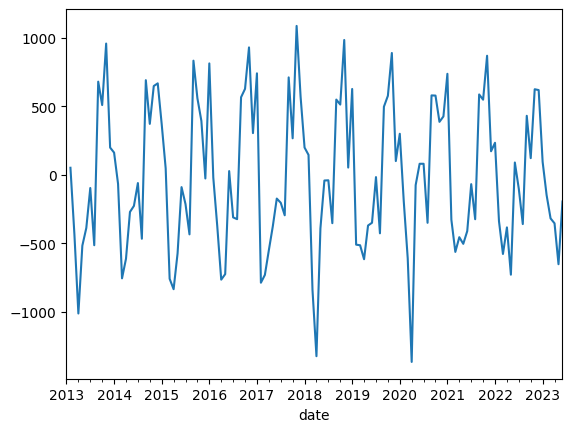

In [77]:
df_month['First_diff'] = df_month['consommation_brute_electricite_rte'] - df_month['consommation_brute_electricite_rte'].shift(1)
df_month['First_diff'].plot()

In [72]:
test_p_value(df_month['First_diff'].dropna())

P-value:  2.8100624856572908e-08
Reject null hypothesis, data is stationary


<AxesSubplot: xlabel='date'>

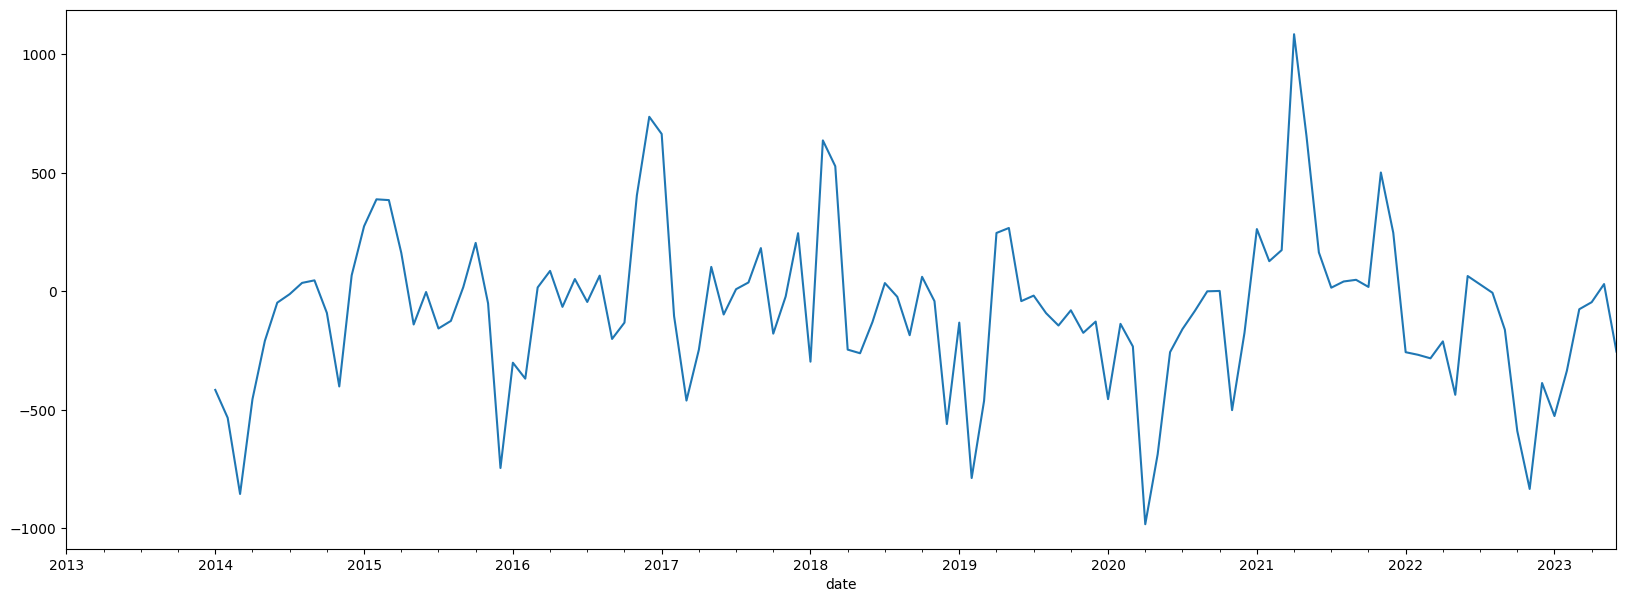

In [82]:
plt.figure(figsize=(20, 7))
df_month['seasonal_diff'] = df_month['consommation_brute_electricite_rte'] - df_month['consommation_brute_electricite_rte'].shift(12)
df_month['seasonal_diff'].plot()

In [83]:
test_p_value(df_month['seasonal_diff'].dropna())

P-value:  0.14528566733344334
Do not reject null hypothesis, data is not stationary


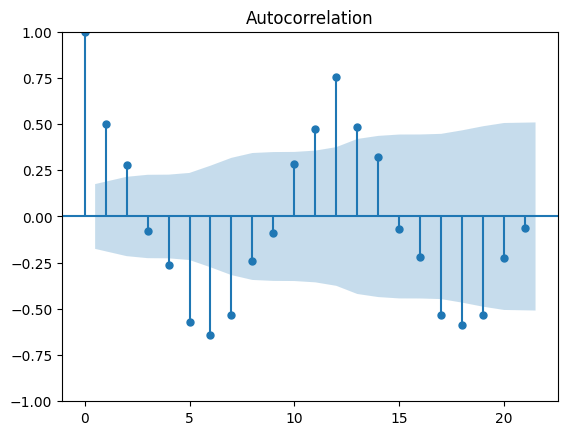

In [79]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

first_diff = plot_acf(df_month['First_diff'].dropna())

/home/apprenant/miniconda3/envs/sklearn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


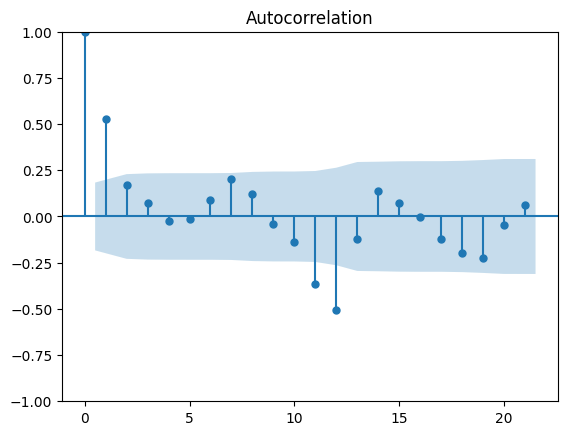

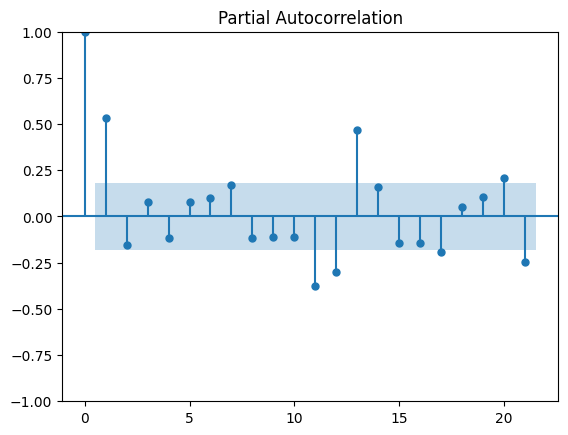

In [86]:
p1 = plot_acf(df_month['seasonal_diff'].dropna())
p2 = plot_pacf(df_month['seasonal_diff'].dropna())

In [88]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(df_month['consommation_brute_electricite_rte'],order=(0,1,0),seasonal_order=(1,1,1,12))


In [89]:
results = model.fit()
results.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.24291D+00    |proj g|=  7.66432D-02

At iterate    5    f=  6.20329D+00    |proj g|=  3.44571D-03

At iterate   10    f=  6.20311D+00    |proj g|=  1.97923D-03

At iterate   15    f=  6.19708D+00    |proj g|=  5.85190D-02

At iterate   20    f=  6.19419D+00    |proj g|=  4.17402D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     24      1     0     0   4.174D-05   6.194D+00
  F =   6.1941901277882110     

CONVERG

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:     consommation_brute_electricite_rte   No. Observations:                  126
Model:               SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -780.468
Date:                                Wed, 13 Sep 2023   AIC                           1566.936
Time:                                        15:28:53   BIC                           1575.118
Sample:                                    01-31-2013   HQIC                          1570.256
                                         - 06-30-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.1139      0.115     -0.992      0.321      -0.339       0.111
ma.S.L12      -0.9655      0.750     -1.288      0.198      -2.435       0.504
sigma2      4.671e+04   3.21e+04      1.455      0.146   -1.62e+04     1.1e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.61   Jarque-Bera (JB):                 3.90
Prob(Q):                              0.06   Prob(JB):                         0.14
Heteroskedasticity (H):               1.22   Skew:                            -0.43
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot: xlabel='date'>

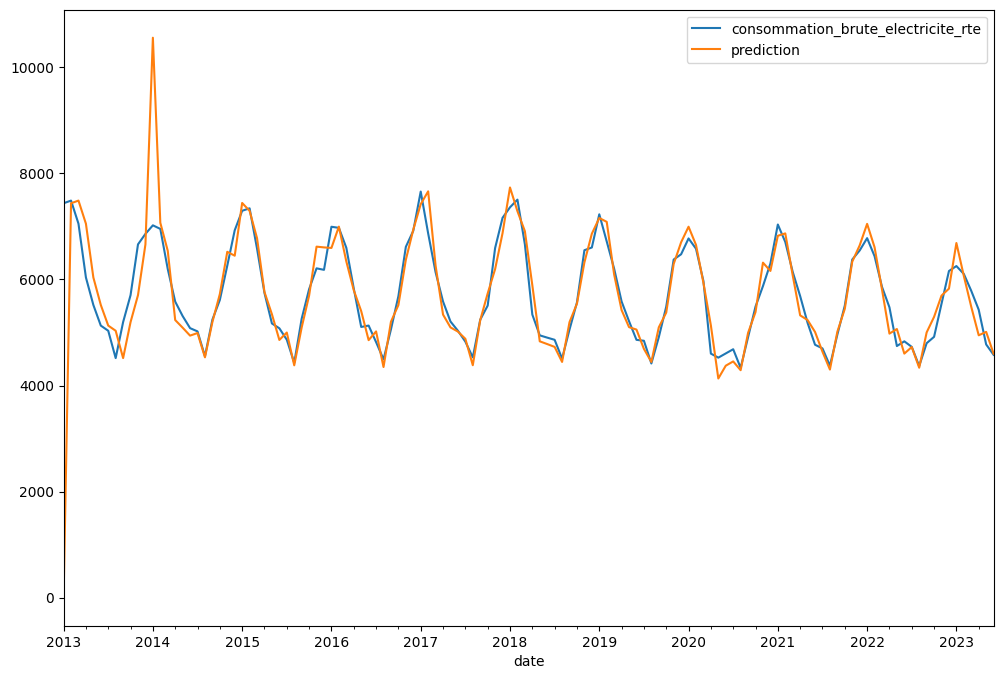

In [90]:
df_month['prediction'] = results.predict()
df_month[['consommation_brute_electricite_rte','prediction']].plot(figsize=(12,8))

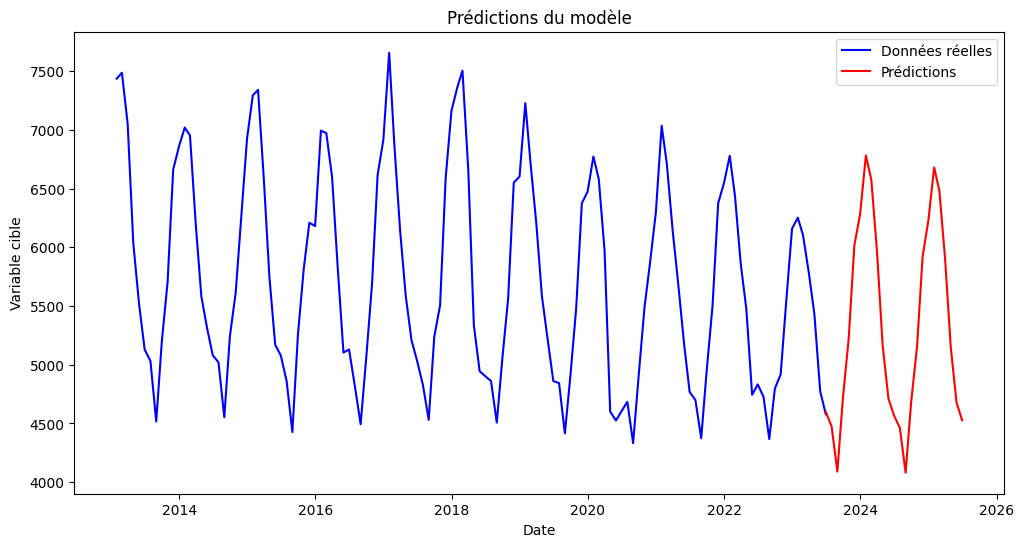

In [100]:
predictions = results.predict(start=125, end=149)
plt.figure(figsize=(12, 6))
plt.plot(df_month.index, df_month['consommation_brute_electricite_rte'], label='Données réelles', color='blue')
plt.plot(predictions.index, predictions.values, label='Prédictions', color='red')
plt.xlabel('Date')
plt.ylabel('Variable cible')
plt.title('Prédictions du modèle')
plt.legend()
plt.show()